In [1]:
import h5py
import os
import numpy as np

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

file = h5py.File('processed_data.h5','r+') 

#Retrieves all the preprocessed training and validation\testing data from a file

X_train = file['X_train'][...]
Y_train = file['Y_train'][...]
X_val = file['X_val'][...]
Y_val = file['Y_val'][...]
X_test = file['X_test'][...]
Y_test = file['Y_test'][...]

# Unpickles and retrieves class names and other meta informations of the database
classes = unpickle('cifar-10-batches-py/batches.meta') #keyword for label = label_names

print("Training sample shapes (input and output): "+str(X_train.shape)+" "+str(Y_train.shape))
print("Validation sample shapes (input and output): "+str(X_val.shape)+" "+str(Y_val.shape))
print("Testing sample shapes (input and output): "+str(X_test.shape)+" "+str(Y_test.shape))


Training sample shapes (input and output): (50000, 32, 32, 3) (50000, 10)
Validation sample shapes (input and output): (10000, 32, 32, 3) (10000, 10)
Testing sample shapes (input and output): (10000, 32, 32, 3) (10000, 10)


In [2]:
# Creates nested list. The outer list will list all the classess (0-9). And each of the classes represent the inner list which list all
#training data that belongs to that class. I used list because it is easy to keep on adding dynamically. Ndarrays may have needed 
#a predifined shape

classes_num = len(classes['label_names']) #classes_num = no. of classes

# Here, I am creating a special variable X_train_F which is basically a nested list.
# The outermost list of X_train_F will be a list of all the class values (0-9 where each value correspond to a class name)
# Each elements (class values) of the outermost list is actually also a list; a list of all the example data belonging
# to the particular class which corresponds to class value under which the data is listed. 

X_train_F = []

for i in xrange(0,classes_num):
    X_train_F.append([])


for i in xrange(0,len(X_train)):
    l = np.argmax(Y_train[i]) #l for label (in this case it's basically the index of class value elemenmts)  
    #(Y_train is one hot encoded. Argmax returns the index for maximum value which should be 1 and
    # that index should indicate the value)
    X_train_F[l].append(X_train[i])
    

In [3]:
import matplotlib.pyplot as plt
from scipy.misc import toimage
from scipy.misc import imresize
%matplotlib inline

#function for showing pictures in grid along with labels

def picgrid(X_train,Y_train,gray=0):
    plt.figure(figsize=(7,7))
    ax=[]
    for i in xrange(0,25):
        img = toimage(X_train[i])
        ax.append(plt.subplot(5,5,i+1))
        ax[i].set_title( classes['label_names'][np.argmax(Y_train[i])],y=-0.3)
        ax[i].set_axis_off()
        if gray==0:
            plt.imshow(img)
        else:
            plt.imshow(img,cmap='gray')
    plt.subplots_adjust(hspace=0.3)
    plt.axis('off')
    plt.show()

Sample arranged images in a batch: 


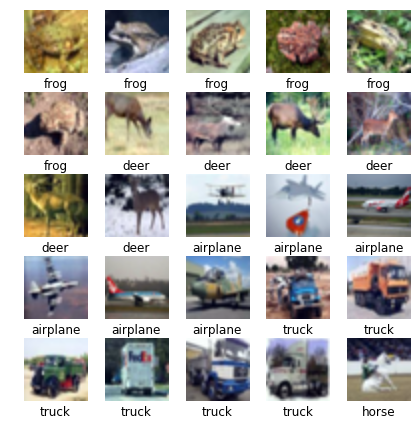

In [4]:
import random


smoothing_factor = 0.1 #for label smoothing

def create_batches(batch_size,classes_num):
   
    s = int(batch_size/classes_num) #s denotes samples taken from each class to create the batch.
    no_of_batches = int(len(X_train)/batch_size)
    
    shuffled_indices_per_class =[]
    for i in xrange(0,classes_num):
        temp = np.arange(len(X_train_F[i]))
        np.random.shuffle(temp)
        shuffled_indices_per_class.append(temp)
        
    batches_X = []
    batches_Y = []
        
    for i in xrange(no_of_batches):
        
        shuffled_class_indices = np.arange(classes_num)
        np.random.shuffle(shuffled_class_indices)
        
        batch_Y = np.zeros((batch_size,classes_num),np.float32)
        batch_X = np.zeros((batch_size,32,32,3),np.float32)
        
        for index in xrange(0,classes_num):
            class_index = shuffled_class_indices[index]
            for j in xrange(0,s):
                batch_X[(index*s)+j] = X_train_F[class_index][shuffled_indices_per_class[class_index][i*s+j]] # Assign the s chosen random samples to the training batch
                batch_Y[(index*s)+j][class_index] = 1
                batch_Y[(index*s)+j] = (1-smoothing_factor)*batch_Y[(index*s)+j] + smoothing_factor/classes_num
        
        rs = batch_size - s*classes_num #rs denotes no. of random samples from random classes to take
                                        #in order to fill the batch if batch isn't divisble by classes_num
        #fill the rest of the batch with random data
        rand = random.sample(np.arange(len(X_train)),rs)
        j=0
        for k in xrange(s*classes_num,batch_size):
            batch_X[k] = X_train[int(rand[j])]
            batch_Y[k] = Y_train[int(rand[j])]
            batch_Y[k] = (1-smoothing_factor)*batch_Y[k] + smoothing_factor/classes_num
            j+=1

        batches_X.append(batch_X)
        batches_Y.append(batch_Y)
    
    return batches_X,batches_Y

batches_X,batches_Y = create_batches(64,classes_num) # A demo of the function at work

# Since each batch will have almost equal no. of cases from each class, no batch should be biased towards some particular classes

sample = random.randint(0,len(batches_X))
print "Sample arranged images in a batch: "
picgrid(batches_X[sample],batches_Y[sample])

Sample batch training images after augmentation:


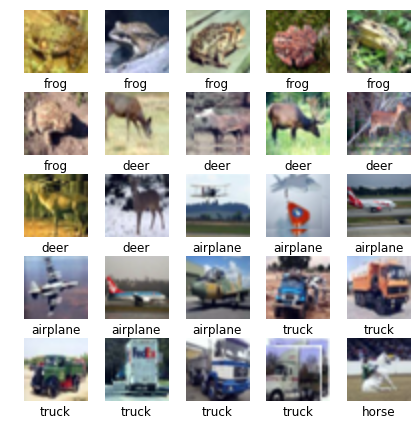

In [5]:
def random_crop(img):
    #result = np.zeros_like((img))
    c = np.random.randint(0,5)
    if c==0:
        crop = img[4:32,0:-4]
    elif c==1:
        crop = img[0:-4,0:-4]
    elif c==2:
        crop = img[2:-2,2:-2]
    elif c==3:
        crop = img[4:32,4:32]
    elif c==4:
        crop = img[0:-4,4:32]
    
    #translating cropped position
    #over the original image
    c = np.random.randint(0,5)
    if c==0:
        img[4:32,0:-4] = crop[:]
    elif c==1:
        img[0:-4,0:-4] = crop[:]
    elif c==2:
        img[2:-2,2:-2] = crop[:]
    elif c==3:
        img[4:32,4:32] = crop[:]
    elif c==4:
        img[0:-4,4:32] = crop[:]
        
    return img

def augment_batch(batch_X): #will be used to modify images realtime during training (real time data augmentation)
    
    aug_batch_X = np.zeros((len(batch_X),32,32,3))
   
    for i in xrange(0,len(batch_X)):
        
        hf = np.random.randint(0,2)
        
        if hf == 1: #hf denotes horizontal flip. 50-50 random chance to apply horizontal flip on images,
            batch_X[i] = np.fliplr(batch_X[i])
       
        # Remove the below cropping to apply random crops. But before that it's better to implement something like mirror padding
        # or any form of padding to increase the dimensions beforehand.
        
        c = np.random.randint(0,3)
        if c==1:
           #one in a three chance for cropping
           #randomly crop 28x28 portions and translate it.
            aug_batch_X[i] = random_crop(batch_X[i])
        else:
            aug_batch_X[i] = batch_X[i]
    
    return aug_batch_X
    
aug_batches_X=[]
for batch in batches_X:
    aug_batch_X = augment_batch(batch)
    aug_batches_X.append(aug_batch_X)

print "Sample batch training images after augmentation:"
picgrid(aug_batches_X[sample],batches_Y[sample])

Sample batch training images after shuffling


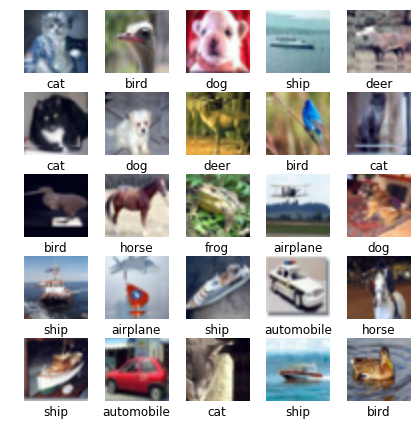

In [6]:
def shuffle_batch(batch_X,batch_Y):
    shuffle = random.sample(np.arange(0,len(batch_X),1,'int'),len(batch_X))
    shuffled_batch_X = []
    shuffled_batch_Y = []
    
    for i in xrange(0,len(batch_X)):
        shuffled_batch_X.append(batch_X[int(shuffle[i])])
        shuffled_batch_Y.append(batch_Y[int(shuffle[i])])
    
    shuffled_batch_X = np.array(shuffled_batch_X)
    shuffled_batch_Y = np.array(shuffled_batch_Y)

    return shuffled_batch_X,shuffled_batch_Y

s_batches_X=[]
s_batches_Y=[]
for i in xrange(len(aug_batches_X)):
    s_batch_X,s_batch_Y = shuffle_batch(aug_batches_X[i],batches_Y[i])
    s_batches_X.append(s_batch_X)
    s_batches_Y.append(s_batch_Y)

print "Sample batch training images after shuffling"
picgrid(s_batches_X[sample],s_batches_Y[sample])

In [7]:
def batch(batch_size): #one shortcut function to execute all necessary functions to create a training batch
    batches_X,batches_Y = create_batches(batch_size,classes_num)
    
    aug_batches_X=[]
    for batch in batches_X:
        aug_batch_X = augment_batch(batch)
        aug_batches_X.append(aug_batch_X)
        
    s_batches_X=[]
    s_batches_Y=[]
    
    for i in xrange(len(aug_batches_X)):
        s_batch_X,s_batch_Y = shuffle_batch(aug_batches_X[i],batches_Y[i])
        s_batches_X.append(s_batch_X)
        s_batches_Y.append(s_batch_Y)
    
    return s_batches_X,s_batches_Y

In [8]:
import tensorflow as tf

#Hyper Parameters!

learning_rate = 0.01
init_lr = learning_rate
batch_size = 64
epochs = 500
layers = 16
beta = 0.0001 #l2 regularization scale
#ensemble = 1 #no. of models to be ensembled (minimum: 1)

K = 8 #(deepening factor)

n_classes = classes_num # another useless step that I made due to certain reasons. 

# tf Graph input

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None,classes_num])
phase = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [9]:

# Create some wrappers for simplicity
def conv2d(x,shape,strides,scope):
    # Conv2D wrapper
    with tf.variable_scope(scope+"regularize",reuse=False):
        W = tf.Variable(tf.truncated_normal(shape=shape,stddev=5e-2))
    b = tf.Variable(tf.truncated_normal(shape=[shape[3]],stddev=5e-2))
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def activate(x,phase):
    #wrapper for performing batch normalization and elu activation
    x = tf.contrib.layers.batch_norm(x, center=True, scale=True,variables_collections=["batch_norm_non_trainable_variables_collection"],updates_collections=None, decay=0.9,is_training=phase,zero_debias_moving_mean=True, fused=True)
    return tf.nn.elu(x)


def wideres33block(X,N,K,iw,bw,s,dropout,phase,scope):
    
    # Creates N no. of 3,3 type residual blocks with dropout that consitute the conv2/3/4 blocks
    # with widening factor K and X as input. s is stride and bw is base width (no. of filters before multiplying with k)
    # iw is input width.
    # (see https://arxiv.org/abs/1605.07146 paper for details on the block)
    # In this case, dropout = probability to keep the neuron enabled.
    # phase = true when training, false otherwise.
    
    conv33_1 = conv2d(X,[3,3,iw,bw*K],s,scope)
    conv33_1 = activate(conv33_1,phase)
    conv33_1 = tf.nn.dropout(conv33_1,dropout)
    
    conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1,scope)
    conv_skip= conv2d(X,[1,1,iw,bw*K],s,scope) #shortcut connection

    
    caddtable = tf.add(conv33_2,conv_skip)
    
    #1st of the N blocks for conv2/3/4 block ends here. The rest of N-1 blocks will be implemented next with a loop.

    for i in range(0,N-1):
        
        C = caddtable
        Cactivated = activate(C,phase)
        
        conv33_1 = conv2d(Cactivated,[3,3,bw*K,bw*K],1,scope)
        conv33_1 = activate(conv33_1,phase)
        
        conv33_1 = tf.nn.dropout(conv33_1,dropout)
            
        conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1,scope)
        caddtable = tf.add(conv33_2,C)
    
    return activate(caddtable,phase)


    
def WRN(x,dropout,phase,layers,K,scope): #Wide residual network

    # 1 conv + 3 convblocks*(3 conv layers *1 group for each block + 2 conv layers*(N-1) groups for each block [total 1+N-1 = N groups]) = layers
    # 3*2*(N-1) = layers - 1 - 3*3
    # N = (layers -10)/6 + 1
    # So N = (layers-4)/6

    N = (layers-4)/6
    
    conv1 = conv2d(x,[3,3,3,16],1,scope)
    conv1 = activate(conv1,phase)

    conv2 = wideres33block(conv1,N,K,16,16,1,dropout,phase,scope)
    conv3 = wideres33block(conv2,N,K,16*K,32,2,dropout,phase,scope)
    conv4 = wideres33block(conv3,N,K,32*K,64,2,dropout,phase,scope)

    pooled = tf.nn.avg_pool(conv4,ksize=[1,8,8,1],strides=[1,1,1,1],padding='VALID')
    
    #Initialize weights and biases for fully connected layers
    with tf.variable_scope(scope+"regularize",reuse=False):
        wd1 = tf.Variable(tf.truncated_normal([1*1*64*K,64*K],stddev=5e-2))
        wout = tf.Variable(tf.truncated_normal([64*K, n_classes]))
    bd1 = tf.Variable(tf.constant(0.1,shape=[64*K]))
    bout = tf.Variable(tf.constant(0.1,shape=[n_classes]))

    # Fully connected layer
    # Reshape pooling layer output to fit fully connected layer input
    fc1 = tf.reshape(pooled, [-1, wd1.get_shape().as_list()[0]])   
    fc1 = tf.add(tf.matmul(fc1, wd1), bd1)
    fc1 = tf.nn.elu(fc1)
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, wout), bout)
    
    return out

In [10]:
# Construct model

model = WRN(x,keep_prob,phase,layers=layers,K=K,scope='1')

#l2 regularization
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='1regularize')

regularizer=0
for i in xrange(len(weights)):
    regularizer += tf.nn.l2_loss(weights[i])
    

#cross entropy loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model,labels=y) + beta*regularizer)


global_step = tf.Variable(0, trainable=False)

#optimizer 
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum = 0.9, 
                                       use_nesterov=True).minimize(cost,global_step=global_step)

# Evaluate model
correct_pred = tf.equal(tf.argmax(model,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
prediction = tf.nn.softmax(logits=model)

# Initializing the variables
init = tf.global_variables_initializer()

In [11]:

with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() # Prepares variable for saving the model
    sess.run(init) #initialize all variables
    step = 1   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    total_loss=0
    total_acc=0
    avg_loss=0
    avg_acc=0
    val_batch_size = batch_size
    
    
    threshold = 0.5 #if training accuracy is 100-threshold or less, training will stop 
    
    while step <= epochs:
        
        
        # A little bit of Learning rate scheduling
        if step == 60:
            learning_rate = 0.01
        elif step == 120:
            learning_rate = 0.004
        elif step == 160:
            learning_rate = 0.0008

        
        batches_X, batches_Y = batch(batch_size)
        
        for i in xrange(len(batches_X)):
            # Run optimization operation (backpropagation)
            _,loss,acc = sess.run([optimizer,cost,accuracy],
                                   feed_dict={x: batches_X[i], y: batches_Y[i], 
                                   keep_prob: 0.7,
                                   phase: True})
            total_loss += loss
            total_acc += acc
            
            if i%100 == 0:
                print "Iter " + str((step-1)*len(batches_X)+i+1) + ", Minibatch Loss= " + \
                  "{:.3f}".format(loss) + ", Minibatch Accuracy= " + \
                  "{:.3f}%".format(acc*100)

     
                      
        total_val_loss=0
        total_val_acc=0
        val_loss=0
        val_acc=0
        avg_val_loss=0
        avg_val_acc=0
            
        i=0
        count=0
        while i<len(X_val):

            if i+val_batch_size<len(X_val):
                val_loss, val_acc = sess.run([cost, accuracy], 
                                            feed_dict={x: X_val[i:i+val_batch_size],
                                                       y: Y_val[i:i+val_batch_size],
                                                       keep_prob: 1,
                                                       phase: False})
            else:
                val_loss, val_acc = sess.run([cost, accuracy], 
                                            feed_dict={x: X_val[i:],
                                                       y: Y_val[i:],
                                                       keep_prob: 1,
                                                       phase: False})
                              
            total_val_loss = total_val_loss + val_loss
            total_val_acc = total_val_acc + val_acc
            count+=1
                
            i+=val_batch_size
  

 
        avg_val_loss = total_val_loss/count # Average validation loss
        avg_val_acc = total_val_acc/count # Average validation accuracy
            
             
        val_loss_list.append(avg_val_loss) # Storing values in list for plotting later on.
        val_acc_list.append(avg_val_acc) # Storing values in list for plotting later on.
            
        avg_loss = total_loss/len(batches_X) # Average mini-batch training loss
        avg_acc = total_acc/len(batches_X)   # Average mini-batch training accuracy
        loss_list.append(avg_loss) # Storing values in list for plotting later on.
        acc_list.append(avg_acc) # Storing values in list for plotting later on.
            
        total_loss=0
        total_acc=0

        print "\nEpoch " + str(step) + ", Validation Loss= " + \
                "{:.3f}".format(avg_val_loss) + ", validation Accuracy= " + \
                "{:.3f}%".format(avg_val_acc*100)+""
        print "Epoch " + str(step) + ", Average Training Loss= " + \
                "{:.3f}".format(avg_loss) + ", Average Training Accuracy= " + \
                "{:.3f}%".format(avg_acc*100)+""
                    
        if avg_val_acc >= best_val_acc: # When better accuracy is received than previous best validation accuracy
                
            best_val_acc = avg_val_acc # update value of best validation accuracy received yet.
            saver.save(sess, 'Model_Backup/model.ckpt') # save_model including model variables (weights, biases etc.)
            print "Checkpoint created!"
                
                
        print ""
            
        if (100-(avg_acc*100)) <= threshold:
            print "\nConvergence Threshold Reached!"
            break
              
        step += 1
        
    print "\nOptimization Finished!\n"
    
    print "Best Validation Accuracy: %.3f%%"%((best_val_acc)*100)
    
    print 'Loading pre-trained weights for the model...'
    saver = tf.train.Saver()
    saver.restore(sess, 'Model_Backup/model.ckpt')
    sess.run(tf.global_variables())
    print '\nRESTORATION COMPLETE\n'
    
    print 'Testing Model Performance...'
    test_batch_size = batch_size
    total_test_loss=0
    total_test_acc=0
    test_loss=0
    test_acc=0
    avg_test_loss=0
    avg_test_acc=0
            
    i=0
    count=0
    while i<len(X_test):
        
        if (i+test_batch_size)<len(X_test):
            test_loss, test_acc = sess.run([cost, accuracy], 
                                         feed_dict={x: X_test[i:i+test_batch_size],
                                                    y: Y_test[i:i+test_batch_size],
                                                    keep_prob: 1,
                                                    phase: False})
        else:
            test_loss, test_acc = sess.run([cost, accuracy], 
                                            feed_dict={x: X_test[i:],
                                                       y: Y_test[i:],
                                                       keep_prob: 1,
                                                       phase: False})
   
        total_test_loss = total_test_loss+test_loss
        total_test_acc = total_test_acc+test_acc
        count+=1
        
        i+=test_batch_size
             
    avg_test_loss = total_test_loss/count # Average test loss
    avg_test_acc = total_test_acc/count # Average test accuracy
    
    print "Test Loss = " + \
          "{:.3f}".format(avg_test_loss) + ", Test Accuracy = " + \
          "{:.3f}%".format(avg_test_acc*100)
    
    

Iter 1, Minibatch Loss= 7.933, Minibatch Accuracy= 7.812%
Iter 101, Minibatch Loss= 3.545, Minibatch Accuracy= 23.438%
Iter 201, Minibatch Loss= 3.227, Minibatch Accuracy= 37.500%
Iter 301, Minibatch Loss= 3.356, Minibatch Accuracy= 28.125%
Iter 401, Minibatch Loss= 3.231, Minibatch Accuracy= 28.125%
Iter 501, Minibatch Loss= 3.242, Minibatch Accuracy= 29.688%
Iter 601, Minibatch Loss= 3.349, Minibatch Accuracy= 28.125%
Iter 701, Minibatch Loss= 3.105, Minibatch Accuracy= 37.500%

Epoch 1, Validation Loss= 2.971, validation Accuracy= 38.754%
Epoch 1, Average Training Loss= 4.991, Average Training Accuracy= 30.964%
Checkpoint created!

Iter 782, Minibatch Loss= 3.192, Minibatch Accuracy= 40.625%
Iter 882, Minibatch Loss= 3.204, Minibatch Accuracy= 40.625%
Iter 982, Minibatch Loss= 3.121, Minibatch Accuracy= 39.062%
Iter 1082, Minibatch Loss= 3.060, Minibatch Accuracy= 53.125%
Iter 1182, Minibatch Loss= 3.025, Minibatch Accuracy= 35.938%
Iter 1282, Minibatch Loss= 3.043, Minibatch Accura

Iter 10073, Minibatch Loss= 2.309, Minibatch Accuracy= 67.188%

Epoch 13, Validation Loss= 1.904, validation Accuracy= 71.825%
Epoch 13, Average Training Loss= 2.280, Average Training Accuracy= 70.280%
Checkpoint created!

Iter 10154, Minibatch Loss= 2.229, Minibatch Accuracy= 73.438%
Iter 10254, Minibatch Loss= 2.107, Minibatch Accuracy= 76.562%
Iter 10354, Minibatch Loss= 2.218, Minibatch Accuracy= 67.188%
Iter 10454, Minibatch Loss= 2.162, Minibatch Accuracy= 71.875%
Iter 10554, Minibatch Loss= 2.247, Minibatch Accuracy= 75.000%
Iter 10654, Minibatch Loss= 2.249, Minibatch Accuracy= 67.188%
Iter 10754, Minibatch Loss= 2.261, Minibatch Accuracy= 71.875%
Iter 10854, Minibatch Loss= 2.208, Minibatch Accuracy= 71.875%

Epoch 14, Validation Loss= 1.895, validation Accuracy= 71.935%
Epoch 14, Average Training Loss= 2.235, Average Training Accuracy= 71.737%
Checkpoint created!

Iter 10935, Minibatch Loss= 2.456, Minibatch Accuracy= 59.375%
Iter 11035, Minibatch Loss= 2.209, Minibatch Accur

Iter 19626, Minibatch Loss= 1.884, Minibatch Accuracy= 84.375%
Iter 19726, Minibatch Loss= 1.782, Minibatch Accuracy= 85.938%
Iter 19826, Minibatch Loss= 1.811, Minibatch Accuracy= 81.250%
Iter 19926, Minibatch Loss= 1.783, Minibatch Accuracy= 82.812%
Iter 20026, Minibatch Loss= 1.821, Minibatch Accuracy= 85.938%
Iter 20126, Minibatch Loss= 1.819, Minibatch Accuracy= 82.812%
Iter 20226, Minibatch Loss= 1.722, Minibatch Accuracy= 87.500%

Epoch 26, Validation Loss= 1.448, validation Accuracy= 82.514%
Epoch 26, Average Training Loss= 1.845, Average Training Accuracy= 82.202%
Checkpoint created!

Iter 20307, Minibatch Loss= 1.638, Minibatch Accuracy= 93.750%
Iter 20407, Minibatch Loss= 1.929, Minibatch Accuracy= 78.125%
Iter 20507, Minibatch Loss= 1.825, Minibatch Accuracy= 84.375%
Iter 20607, Minibatch Loss= 1.787, Minibatch Accuracy= 82.812%
Iter 20707, Minibatch Loss= 1.805, Minibatch Accuracy= 79.688%
Iter 20807, Minibatch Loss= 1.819, Minibatch Accuracy= 85.938%
Iter 20907, Minibatch

Iter 29498, Minibatch Loss= 1.614, Minibatch Accuracy= 84.375%
Iter 29598, Minibatch Loss= 1.486, Minibatch Accuracy= 89.062%

Epoch 38, Validation Loss= 1.205, validation Accuracy= 86.276%
Epoch 38, Average Training Loss= 1.593, Average Training Accuracy= 87.278%
Checkpoint created!

Iter 29679, Minibatch Loss= 1.535, Minibatch Accuracy= 85.938%
Iter 29779, Minibatch Loss= 1.554, Minibatch Accuracy= 92.188%
Iter 29879, Minibatch Loss= 1.489, Minibatch Accuracy= 93.750%
Iter 29979, Minibatch Loss= 1.640, Minibatch Accuracy= 79.688%
Iter 30079, Minibatch Loss= 1.634, Minibatch Accuracy= 84.375%
Iter 30179, Minibatch Loss= 1.526, Minibatch Accuracy= 90.625%
Iter 30279, Minibatch Loss= 1.580, Minibatch Accuracy= 87.500%
Iter 30379, Minibatch Loss= 1.742, Minibatch Accuracy= 82.812%

Epoch 39, Validation Loss= 1.187, validation Accuracy= 86.435%
Epoch 39, Average Training Loss= 1.579, Average Training Accuracy= 87.356%
Checkpoint created!

Iter 30460, Minibatch Loss= 1.536, Minibatch Accur

Iter 39151, Minibatch Loss= 1.509, Minibatch Accuracy= 87.500%
Iter 39251, Minibatch Loss= 1.470, Minibatch Accuracy= 85.938%
Iter 39351, Minibatch Loss= 1.561, Minibatch Accuracy= 81.250%
Iter 39451, Minibatch Loss= 1.340, Minibatch Accuracy= 93.750%
Iter 39551, Minibatch Loss= 1.429, Minibatch Accuracy= 89.062%
Iter 39651, Minibatch Loss= 1.385, Minibatch Accuracy= 90.625%
Iter 39751, Minibatch Loss= 1.443, Minibatch Accuracy= 87.500%

Epoch 51, Validation Loss= 1.016, validation Accuracy= 88.187%
Epoch 51, Average Training Loss= 1.395, Average Training Accuracy= 90.477%
Checkpoint created!

Iter 39832, Minibatch Loss= 1.344, Minibatch Accuracy= 89.062%
Iter 39932, Minibatch Loss= 1.456, Minibatch Accuracy= 87.500%
Iter 40032, Minibatch Loss= 1.363, Minibatch Accuracy= 92.188%
Iter 40132, Minibatch Loss= 1.374, Minibatch Accuracy= 92.188%
Iter 40232, Minibatch Loss= 1.370, Minibatch Accuracy= 90.625%
Iter 40332, Minibatch Loss= 1.367, Minibatch Accuracy= 90.625%
Iter 40432, Minibatch

Iter 49123, Minibatch Loss= 1.283, Minibatch Accuracy= 90.625%

Epoch 63, Validation Loss= 0.908, validation Accuracy= 89.013%
Epoch 63, Average Training Loss= 1.246, Average Training Accuracy= 92.826%

Iter 49204, Minibatch Loss= 1.248, Minibatch Accuracy= 95.312%
Iter 49304, Minibatch Loss= 1.207, Minibatch Accuracy= 90.625%
Iter 49404, Minibatch Loss= 1.273, Minibatch Accuracy= 90.625%
Iter 49504, Minibatch Loss= 1.157, Minibatch Accuracy= 98.438%
Iter 49604, Minibatch Loss= 1.134, Minibatch Accuracy= 100.000%
Iter 49704, Minibatch Loss= 1.261, Minibatch Accuracy= 89.062%
Iter 49804, Minibatch Loss= 1.350, Minibatch Accuracy= 89.062%
Iter 49904, Minibatch Loss= 1.235, Minibatch Accuracy= 95.312%

Epoch 64, Validation Loss= 0.897, validation Accuracy= 88.794%
Epoch 64, Average Training Loss= 1.236, Average Training Accuracy= 93.128%

Iter 49985, Minibatch Loss= 1.174, Minibatch Accuracy= 96.875%
Iter 50085, Minibatch Loss= 1.219, Minibatch Accuracy= 92.188%
Iter 50185, Minibatch Loss

Iter 58976, Minibatch Loss= 1.133, Minibatch Accuracy= 95.312%
Iter 59076, Minibatch Loss= 1.109, Minibatch Accuracy= 92.188%
Iter 59176, Minibatch Loss= 1.062, Minibatch Accuracy= 100.000%
Iter 59276, Minibatch Loss= 1.140, Minibatch Accuracy= 93.750%

Epoch 76, Validation Loss= 0.814, validation Accuracy= 89.431%
Epoch 76, Average Training Loss= 1.122, Average Training Accuracy= 94.616%

Iter 59357, Minibatch Loss= 1.115, Minibatch Accuracy= 92.188%
Iter 59457, Minibatch Loss= 1.143, Minibatch Accuracy= 95.312%
Iter 59557, Minibatch Loss= 1.078, Minibatch Accuracy= 96.875%
Iter 59657, Minibatch Loss= 1.131, Minibatch Accuracy= 95.312%
Iter 59757, Minibatch Loss= 1.087, Minibatch Accuracy= 96.875%
Iter 59857, Minibatch Loss= 1.120, Minibatch Accuracy= 93.750%
Iter 59957, Minibatch Loss= 1.144, Minibatch Accuracy= 92.188%
Iter 60057, Minibatch Loss= 1.050, Minibatch Accuracy= 98.438%

Epoch 77, Validation Loss= 0.795, validation Accuracy= 89.879%
Epoch 77, Average Training Loss= 1.112,

Iter 68829, Minibatch Loss= 1.070, Minibatch Accuracy= 92.188%
Iter 68929, Minibatch Loss= 0.992, Minibatch Accuracy= 100.000%
Iter 69029, Minibatch Loss= 0.981, Minibatch Accuracy= 98.438%
Iter 69129, Minibatch Loss= 0.991, Minibatch Accuracy= 98.438%
Iter 69229, Minibatch Loss= 0.997, Minibatch Accuracy= 98.438%
Iter 69329, Minibatch Loss= 1.065, Minibatch Accuracy= 93.750%
Iter 69429, Minibatch Loss= 0.945, Minibatch Accuracy= 100.000%

Epoch 89, Validation Loss= 0.723, validation Accuracy= 90.297%
Epoch 89, Average Training Loss= 1.017, Average Training Accuracy= 96.119%

Iter 69510, Minibatch Loss= 1.043, Minibatch Accuracy= 95.312%
Iter 69610, Minibatch Loss= 0.979, Minibatch Accuracy= 100.000%
Iter 69710, Minibatch Loss= 0.972, Minibatch Accuracy= 98.438%
Iter 69810, Minibatch Loss= 0.957, Minibatch Accuracy= 98.438%
Iter 69910, Minibatch Loss= 0.978, Minibatch Accuracy= 100.000%
Iter 70010, Minibatch Loss= 1.044, Minibatch Accuracy= 95.312%
Iter 70110, Minibatch Loss= 1.026, Mi


Epoch 101, Validation Loss= 0.646, validation Accuracy= 91.551%
Epoch 101, Average Training Loss= 0.944, Average Training Accuracy= 96.837%
Checkpoint created!

Iter 78882, Minibatch Loss= 0.995, Minibatch Accuracy= 95.312%
Iter 78982, Minibatch Loss= 0.941, Minibatch Accuracy= 93.750%
Iter 79082, Minibatch Loss= 0.909, Minibatch Accuracy= 98.438%
Iter 79182, Minibatch Loss= 0.924, Minibatch Accuracy= 98.438%
Iter 79282, Minibatch Loss= 0.932, Minibatch Accuracy= 95.312%
Iter 79382, Minibatch Loss= 0.896, Minibatch Accuracy= 98.438%
Iter 79482, Minibatch Loss= 0.910, Minibatch Accuracy= 98.438%
Iter 79582, Minibatch Loss= 0.931, Minibatch Accuracy= 98.438%

Epoch 102, Validation Loss= 0.660, validation Accuracy= 90.884%
Epoch 102, Average Training Loss= 0.935, Average Training Accuracy= 97.009%

Iter 79663, Minibatch Loss= 0.908, Minibatch Accuracy= 98.438%
Iter 79763, Minibatch Loss= 0.908, Minibatch Accuracy= 96.875%
Iter 79863, Minibatch Loss= 0.931, Minibatch Accuracy= 98.438%
Ite

Iter 88754, Minibatch Loss= 0.889, Minibatch Accuracy= 96.875%
Iter 88854, Minibatch Loss= 0.874, Minibatch Accuracy= 95.312%
Iter 88954, Minibatch Loss= 0.847, Minibatch Accuracy= 98.438%

Epoch 114, Validation Loss= 0.598, validation Accuracy= 91.501%
Epoch 114, Average Training Loss= 0.877, Average Training Accuracy= 97.447%

Iter 89035, Minibatch Loss= 0.936, Minibatch Accuracy= 92.188%
Iter 89135, Minibatch Loss= 0.899, Minibatch Accuracy= 96.875%
Iter 89235, Minibatch Loss= 0.843, Minibatch Accuracy= 98.438%
Iter 89335, Minibatch Loss= 0.856, Minibatch Accuracy= 98.438%
Iter 89435, Minibatch Loss= 0.839, Minibatch Accuracy= 98.438%
Iter 89535, Minibatch Loss= 0.859, Minibatch Accuracy= 98.438%
Iter 89635, Minibatch Loss= 0.969, Minibatch Accuracy= 90.625%
Iter 89735, Minibatch Loss= 0.907, Minibatch Accuracy= 95.312%

Epoch 115, Validation Loss= 0.601, validation Accuracy= 91.073%
Epoch 115, Average Training Loss= 0.870, Average Training Accuracy= 97.619%

Iter 89816, Minibatch L

Iter 98507, Minibatch Loss= 0.815, Minibatch Accuracy= 98.438%
Iter 98607, Minibatch Loss= 0.824, Minibatch Accuracy= 98.438%
Iter 98707, Minibatch Loss= 0.805, Minibatch Accuracy= 100.000%
Iter 98807, Minibatch Loss= 0.829, Minibatch Accuracy= 96.875%
Iter 98907, Minibatch Loss= 0.803, Minibatch Accuracy= 100.000%
Iter 99007, Minibatch Loss= 0.848, Minibatch Accuracy= 95.312%
Iter 99107, Minibatch Loss= 0.804, Minibatch Accuracy= 98.438%

Epoch 127, Validation Loss= 0.554, validation Accuracy= 91.580%
Epoch 127, Average Training Loss= 0.825, Average Training Accuracy= 97.913%

Iter 99188, Minibatch Loss= 0.821, Minibatch Accuracy= 98.438%
Iter 99288, Minibatch Loss= 0.808, Minibatch Accuracy= 100.000%
Iter 99388, Minibatch Loss= 0.813, Minibatch Accuracy= 98.438%
Iter 99488, Minibatch Loss= 0.815, Minibatch Accuracy= 96.875%
Iter 99588, Minibatch Loss= 0.819, Minibatch Accuracy= 98.438%
Iter 99688, Minibatch Loss= 0.846, Minibatch Accuracy= 98.438%
Iter 99788, Minibatch Loss= 0.803, M

Iter 108379, Minibatch Loss= 0.786, Minibatch Accuracy= 96.875%
Iter 108479, Minibatch Loss= 0.798, Minibatch Accuracy= 96.875%

Epoch 139, Validation Loss= 0.527, validation Accuracy= 91.650%
Epoch 139, Average Training Loss= 0.784, Average Training Accuracy= 98.211%

Iter 108560, Minibatch Loss= 0.767, Minibatch Accuracy= 98.438%
Iter 108660, Minibatch Loss= 0.756, Minibatch Accuracy= 100.000%
Iter 108760, Minibatch Loss= 0.754, Minibatch Accuracy= 100.000%
Iter 108860, Minibatch Loss= 0.794, Minibatch Accuracy= 98.438%
Iter 108960, Minibatch Loss= 0.791, Minibatch Accuracy= 96.875%
Iter 109060, Minibatch Loss= 0.773, Minibatch Accuracy= 98.438%
Iter 109160, Minibatch Loss= 0.811, Minibatch Accuracy= 96.875%
Iter 109260, Minibatch Loss= 0.785, Minibatch Accuracy= 98.438%

Epoch 140, Validation Loss= 0.519, validation Accuracy= 91.909%
Epoch 140, Average Training Loss= 0.781, Average Training Accuracy= 98.153%
Checkpoint created!

Iter 109341, Minibatch Loss= 0.750, Minibatch Accuracy

Iter 117932, Minibatch Loss= 0.756, Minibatch Accuracy= 96.875%
Iter 118032, Minibatch Loss= 0.738, Minibatch Accuracy= 100.000%
Iter 118132, Minibatch Loss= 0.756, Minibatch Accuracy= 98.438%
Iter 118232, Minibatch Loss= 0.761, Minibatch Accuracy= 95.312%
Iter 118332, Minibatch Loss= 0.746, Minibatch Accuracy= 100.000%
Iter 118432, Minibatch Loss= 0.756, Minibatch Accuracy= 96.875%
Iter 118532, Minibatch Loss= 0.756, Minibatch Accuracy= 98.438%
Iter 118632, Minibatch Loss= 0.803, Minibatch Accuracy= 96.875%

Epoch 152, Validation Loss= 0.496, validation Accuracy= 92.188%
Epoch 152, Average Training Loss= 0.749, Average Training Accuracy= 98.407%
Checkpoint created!

Iter 118713, Minibatch Loss= 0.750, Minibatch Accuracy= 98.438%
Iter 118813, Minibatch Loss= 0.773, Minibatch Accuracy= 96.875%
Iter 118913, Minibatch Loss= 0.743, Minibatch Accuracy= 100.000%
Iter 119013, Minibatch Loss= 0.748, Minibatch Accuracy= 100.000%
Iter 119113, Minibatch Loss= 0.734, Minibatch Accuracy= 98.438%
It

Iter 127804, Minibatch Loss= 0.710, Minibatch Accuracy= 100.000%
Iter 127904, Minibatch Loss= 0.725, Minibatch Accuracy= 98.438%
Iter 128004, Minibatch Loss= 0.749, Minibatch Accuracy= 96.875%

Epoch 164, Validation Loss= 0.483, validation Accuracy= 91.750%
Epoch 164, Average Training Loss= 0.723, Average Training Accuracy= 98.538%

Iter 128085, Minibatch Loss= 0.708, Minibatch Accuracy= 100.000%
Iter 128185, Minibatch Loss= 0.707, Minibatch Accuracy= 98.438%
Iter 128285, Minibatch Loss= 0.743, Minibatch Accuracy= 98.438%
Iter 128385, Minibatch Loss= 0.691, Minibatch Accuracy= 100.000%
Iter 128485, Minibatch Loss= 0.703, Minibatch Accuracy= 98.438%
Iter 128585, Minibatch Loss= 0.704, Minibatch Accuracy= 100.000%
Iter 128685, Minibatch Loss= 0.725, Minibatch Accuracy= 98.438%
Iter 128785, Minibatch Loss= 0.754, Minibatch Accuracy= 95.312%

Epoch 165, Validation Loss= 0.479, validation Accuracy= 92.138%
Epoch 165, Average Training Loss= 0.723, Average Training Accuracy= 98.470%

Iter 128

Iter 137457, Minibatch Loss= 0.684, Minibatch Accuracy= 98.438%
Iter 137557, Minibatch Loss= 0.695, Minibatch Accuracy= 100.000%
Iter 137657, Minibatch Loss= 0.677, Minibatch Accuracy= 100.000%
Iter 137757, Minibatch Loss= 0.736, Minibatch Accuracy= 96.875%
Iter 137857, Minibatch Loss= 0.689, Minibatch Accuracy= 100.000%
Iter 137957, Minibatch Loss= 0.692, Minibatch Accuracy= 100.000%
Iter 138057, Minibatch Loss= 0.716, Minibatch Accuracy= 96.875%
Iter 138157, Minibatch Loss= 0.756, Minibatch Accuracy= 93.750%

Epoch 177, Validation Loss= 0.473, validation Accuracy= 91.889%
Epoch 177, Average Training Loss= 0.703, Average Training Accuracy= 98.484%

Iter 138238, Minibatch Loss= 0.697, Minibatch Accuracy= 100.000%
Iter 138338, Minibatch Loss= 0.725, Minibatch Accuracy= 96.875%
Iter 138438, Minibatch Loss= 0.682, Minibatch Accuracy= 100.000%
Iter 138538, Minibatch Loss= 0.716, Minibatch Accuracy= 96.875%
Iter 138638, Minibatch Loss= 0.697, Minibatch Accuracy= 98.438%
Iter 138738, Minibat

Iter 147329, Minibatch Loss= 0.666, Minibatch Accuracy= 100.000%
Iter 147429, Minibatch Loss= 0.666, Minibatch Accuracy= 98.438%
Iter 147529, Minibatch Loss= 0.708, Minibatch Accuracy= 96.875%

Epoch 189, Validation Loss= 0.450, validation Accuracy= 92.108%
Epoch 189, Average Training Loss= 0.685, Average Training Accuracy= 98.640%

Iter 147610, Minibatch Loss= 0.664, Minibatch Accuracy= 100.000%
Iter 147710, Minibatch Loss= 0.677, Minibatch Accuracy= 98.438%
Iter 147810, Minibatch Loss= 0.673, Minibatch Accuracy= 98.438%
Iter 147910, Minibatch Loss= 0.675, Minibatch Accuracy= 98.438%
Iter 148010, Minibatch Loss= 0.655, Minibatch Accuracy= 100.000%
Iter 148110, Minibatch Loss= 0.683, Minibatch Accuracy= 98.438%
Iter 148210, Minibatch Loss= 0.660, Minibatch Accuracy= 100.000%
Iter 148310, Minibatch Loss= 0.678, Minibatch Accuracy= 98.438%

Epoch 190, Validation Loss= 0.444, validation Accuracy= 92.327%
Epoch 190, Average Training Loss= 0.678, Average Training Accuracy= 98.880%

Iter 148

Iter 156982, Minibatch Loss= 0.674, Minibatch Accuracy= 98.438%
Iter 157082, Minibatch Loss= 0.660, Minibatch Accuracy= 100.000%
Iter 157182, Minibatch Loss= 0.677, Minibatch Accuracy= 98.438%
Iter 157282, Minibatch Loss= 0.660, Minibatch Accuracy= 98.438%
Iter 157382, Minibatch Loss= 0.665, Minibatch Accuracy= 98.438%
Iter 157482, Minibatch Loss= 0.656, Minibatch Accuracy= 98.438%
Iter 157582, Minibatch Loss= 0.663, Minibatch Accuracy= 98.438%
Iter 157682, Minibatch Loss= 0.650, Minibatch Accuracy= 100.000%

Epoch 202, Validation Loss= 0.453, validation Accuracy= 91.879%
Epoch 202, Average Training Loss= 0.670, Average Training Accuracy= 98.656%

Iter 157763, Minibatch Loss= 0.664, Minibatch Accuracy= 98.438%
Iter 157863, Minibatch Loss= 0.655, Minibatch Accuracy= 100.000%
Iter 157963, Minibatch Loss= 0.673, Minibatch Accuracy= 98.438%
Iter 158063, Minibatch Loss= 0.682, Minibatch Accuracy= 98.438%
Iter 158163, Minibatch Loss= 0.718, Minibatch Accuracy= 95.312%
Iter 158263, Minibatch 

KeyboardInterrupt: 

In [12]:
#Saving logs about change of training and validation loss and accuracy over epochs in another file.

import h5py

file = h5py.File('Training_logs.h5','w')
file.create_dataset('val_acc', data=np.array(val_acc_list))
file.create_dataset('val_loss', data=np.array(val_loss_list))
file.create_dataset('acc', data=np.array(acc_list))
file.create_dataset('loss', data=np.array(loss_list))

file.close()

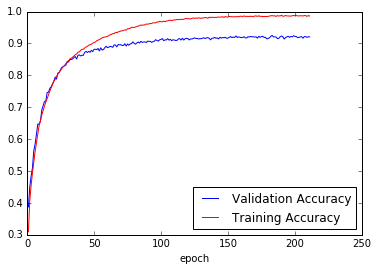

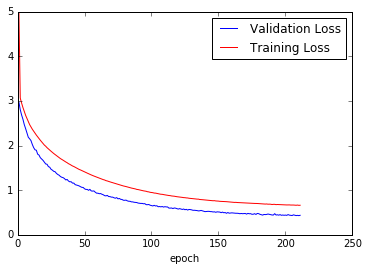

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log = h5py.File('Training_logs.h5','r+') # Loading logs about change of training and validation loss and accuracy over epochs

y1 = log['val_acc'][...]
y2 = log['acc'][...]

x = np.arange(1,len(y1)+1,1) # (1 = starting epoch, len(y1) = no. of epochs, 1 = step) 

plt.plot(x,y1,'b',label='Validation Accuracy') 
plt.plot(x,y2,'r',label='Training Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

y1 = log['val_loss'][...]
y2 = log['loss'][...]

plt.plot(x,y1,'b',label='Validation Loss')
plt.plot(x,y2,'r',label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.show()